✅ Data Berhasil Diload!
Jumlah Baris: 1303, Jumlah Kolom: 13


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00



--- Memulai Proses Cleaning Data ---
✅ Kolom RAM dan Weight berhasil dibersihkan.
✅ Kolom Memory berhasil dipecah menjadi SSD, HDD, dll.
✅ One-Hot Encoding Selesai. Data siap dilatih!
Dimensi Data Baru: (1303, 205)

--- Memulai Training Model ---
✅ Training Selesai (Tanpa Warning)!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

📊 HASIL EVALUASI:
R2 Score (Akurasi Kecocokan): 0.8729 (Target > 0.75)
MAE (Rata-rata Kesalahan): 164.29 Euro


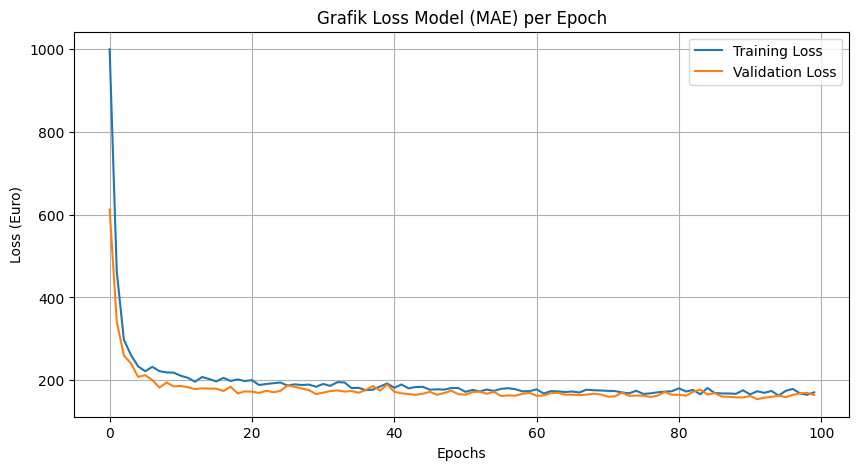

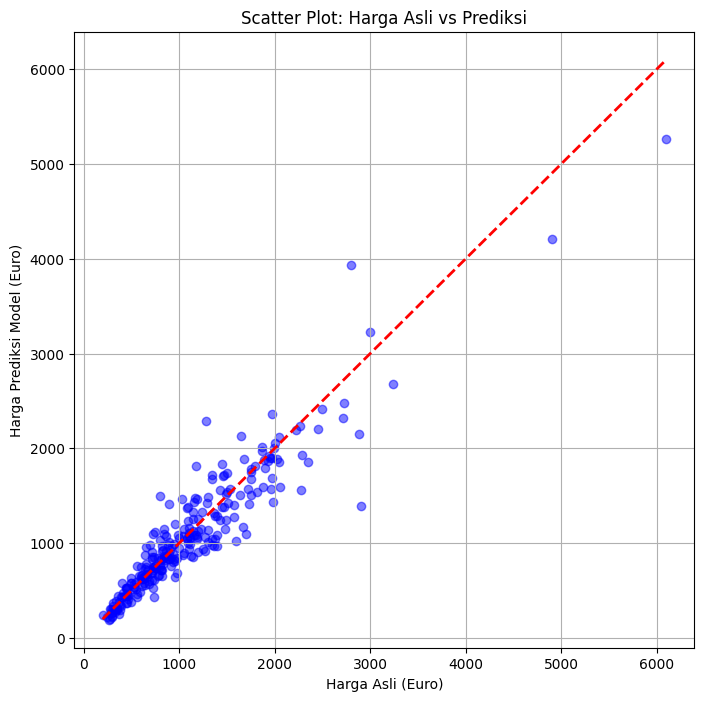


--- ANALISIS PENGARUH MEREK (BRAND EQUITY) ---
Spesifikasi Laptop (Random Sample):
RAM: 8GB, SSD: 256GB, Weight: 1.0499999523162842kg

--- Hasil Simulasi Harga Berdasarkan Merek ---
Merek           | Prediksi Harga (€)  
----------------------------------------
Asus            | € 947.69
Dell            | € 1189.86
HP              | € 1137.20
Lenovo          | € 1200.22
Apple           | € 954.03
Razer           | € 1718.16
----------------------------------------
Analisis: Perbedaan harga di atas murni disebabkan oleh faktor merek,
karena spesifikasi teknis (RAM, SSD, dll) dibuat TETAP sama.


In [4]:
# ==========================================
# BAGIAN 1: IMPORT LIBRARY & LOAD DATA
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error
import tensorflow as tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

try:
    df = pd.read_csv('laptop_data.csv', encoding='latin-1')
    print("✅ Data Berhasil Diload!")
    print(f"Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}")
    display(df.head(3))
except FileNotFoundError:
    print("❌ File 'laptop_data.csv' tidak ditemukan. Mohon upload file dataset terlebih dahulu!")

# ==========================================
# BAGIAN 2: DATA PREPROCESSING (PEMBERSIHAN)
# ==========================================
print("\n--- Memulai Proses Cleaning Data ---")

# 1. Membersihkan RAM (Hapus 'GB') dan Weight (Hapus 'kg')
# Kita gunakan try-except agar aman jika dijalankan ulang
try:
    df['Ram'] = df['Ram'].astype(str).str.replace('GB', '').astype('int32')
    df['Weight'] = df['Weight'].astype(str).str.replace('kg', '').astype('float32')
    print("✅ Kolom RAM dan Weight berhasil dibersihkan.")
except:
    print("⚠️ Kolom RAM/Weight mungkin sudah bersih atau format berbeda.")

# 2. Membersihkan & Memecah Kolom 'Memory' (SSD/HDD)
# Ini bagian paling krusial. Kita pecah jadi 4 kategori: SSD, HDD, Flash Storage, Hybrid
def clean_memory(text):
    text = str(text).lower()
    text = re.sub(r'\.0', '', text)       # Hapus .0
    text = text.replace('tb', '000')      # Ubah 1tb jadi 1000
    text = text.replace('gb', '')         # Hapus gb

    # Inisialisasi
    ssd, hdd, flash, hybrid = 0, 0, 0, 0

    # Pola Regex untuk menangkap angka
    # Contoh data: "128 SSD + 1000 HDD"
    parts = text.split('+') # Pisah jika ada tanda +

    for part in parts:
        number = re.findall(r'\d+', part)
        value = int(number[0]) if number else 0

        if 'ssd' in part:
            ssd = value
        elif 'hdd' in part:
            hdd = value
        elif 'flash storage' in part:
            flash = value
        elif 'hybrid' in part:
            hybrid = value

    return pd.Series([ssd, hdd, flash, hybrid])

# Terapkan fungsi ke kolom Memory
df[['SSD', 'HDD', 'Flash_Storage', 'Hybrid']] = df['Memory'].apply(clean_memory)
# Hapus kolom Memory asli karena sudah tidak dipakai
df.drop(columns=['Memory'], inplace=True)
print("✅ Kolom Memory berhasil dipecah menjadi SSD, HDD, dll.")

# 3. Menyederhanakan Kolom CPU (Opsional tapi disarankan)
def fetch_processor(text):
    text = str(text).split()
    cpu_name = text[0] # Contoh: Intel
    if cpu_name == 'Intel':
        # Ambil 3 kata pertama: Intel Core i5
        return " ".join(text[:3])
    elif cpu_name == 'AMD':
        # Ambil 2 kata pertama: AMD Ryzen
        if 'Ryzen' in text:
            return 'AMD Ryzen'
        else:
            return 'AMD Other'
    else:
        return 'Other Processor'

df['Cpu_Brand'] = df['Cpu'].apply(fetch_processor)
df.drop(columns=['Cpu'], inplace=True) # Hapus kolom Cpu asli

# 4. Hapus kolom yang tidak relevan untuk prediksi
# 'Unnamed: 0' biasanya index sampah, 'Product' nama laptop terlalu spesifik
df.drop(columns=['Unnamed: 0', 'Product', 'Date'], errors='ignore', inplace=True)

# 5. One-Hot Encoding untuk Data Kategori (Company, TypeName, OpSys, dll)
# Kita ambil kolom kategori
cat_columns = ['Company', 'TypeName', 'OpSys', 'ScreenResolution', 'Gpu', 'Cpu_Brand']
# Gunakan pd.get_dummies (cara paling cepat)
df_processed = pd.get_dummies(df, columns=cat_columns, drop_first=True)

print("✅ One-Hot Encoding Selesai. Data siap dilatih!")
print(f"Dimensi Data Baru: {df_processed.shape}")

# ==========================================
# BAGIAN 3: PEMBAGIAN DATA & SCALING
# ==========================================
# Tentukan X (Fitur) dan y (Target Harga)
X = df_processed.drop('Price_in_euros', axis=1)
y = df_processed['Price_in_euros']

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Standarisasi) - Agar Neural Network cepat belajar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ==========================================
# BAGIAN 4: ARSITEKTUR MODEL MLP (REVISI)
# ==========================================
from tensorflow.keras.layers import Input  # Import layer Input eksplisit

model = Sequential()

# 1. Input Layer
model.add(Input(shape=(X_train_scaled.shape[1],)))

# 2. Hidden Layer 1
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2)) # Mencegah Overfitting

# 3. Hidden Layer 2
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# 4. Output Layer (1 Neuron karena Regresi Harga)
model.add(Dense(1))

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='mean_absolute_error',
              metrics=['mean_squared_error'])

print("\n--- Memulai Training Model ---")
# Training
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=100,
                    batch_size=32,
                    verbose=0)
print("✅ Training Selesai (Tanpa Warning)!")

# ==========================================
# BAGIAN 5: EVALUASI MODEL
# ==========================================
# Prediksi
y_pred = model.predict(X_test_scaled)

# Hitung Metrik R2 Score
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n📊 HASIL EVALUASI:")
print(f"R2 Score (Akurasi Kecocokan): {r2:.4f} (Target > 0.75)")
print(f"MAE (Rata-rata Kesalahan): {mae:.2f} Euro")

# Plot Loss Curve (Wajib untuk Laporan)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Grafik Loss Model (MAE) per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss (Euro)')
plt.legend()
plt.grid(True)
plt.show()

# Plot Scatter Prediksi vs Asli
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Garis diagonal sempurna
plt.xlabel('Harga Asli (Euro)')
plt.ylabel('Harga Prediksi Model (Euro)')
plt.title('Scatter Plot: Harga Asli vs Prediksi')
plt.grid(True)
plt.show()

# ==========================================
# BAGIAN 6: ANALISIS EKUITAS MEREK (Simulasi)
# ==========================================
print("\n--- ANALISIS PENGARUH MEREK (BRAND EQUITY) ---")
# Kita ambil 1 sampel laptop dari data test
sample_idx = 0
sample_data = X_test.iloc[sample_idx].copy()
original_price = y_test.iloc[sample_idx]

print(f"Spesifikasi Laptop (Random Sample):")
print(f"RAM: {sample_data['Ram']}GB, SSD: {sample_data['SSD']}GB, Weight: {sample_data['Weight']}kg")

# Fungsi untuk mengubah merek sampel dan memprediksi harga
def predict_with_brand_change(brand_name, input_data):
    # 1. Ubah Series menjadi DataFrame (agar punya nama kolom)
    input_df = input_data.to_frame().T

    # 2. Reset semua kolom brand di DataFrame jadi 0
    for col in input_df.columns:
        if 'Company_' in col:
            input_df[col] = 0

    # 3. Set brand target jadi 1 (jika ada kolomnya)
    target_col = f'Company_{brand_name}'
    if target_col in input_df.columns:
        input_df[target_col] = 1

    # 4. Scaling (sekarang inputnya DataFrame, scaler tidak akan komplain)
    input_scaled = scaler.transform(input_df)

    # 5. Prediksi
    pred_price = model.predict(input_scaled, verbose=0)[0][0]
    return pred_price

# Simulasi Perbandingan Harga
brands_to_test = ['Acer', 'Asus', 'Dell', 'HP', 'Lenovo', 'Apple', 'Razer'] # Sesuaikan dengan merek di dataset
print("\n--- Hasil Simulasi Harga Berdasarkan Merek ---")
print(f"{'Merek':<15} | {'Prediksi Harga (€)':<20}")
print("-" * 40)

for brand in brands_to_test:
    # Cek apakah kolom brand tersebut ada (karena one-hot encoding kadang menghapus yang tidak ada)
    if f'Company_{brand}' in X_test.columns:
        price = predict_with_brand_change(brand, sample_data)
        print(f"{brand:<15} | € {price:.2f}")
    else:
        # Handle jika merek tidak ada di training set
        pass

print("-" * 40)
print("Analisis: Perbedaan harga di atas murni disebabkan oleh faktor merek,\nkarena spesifikasi teknis (RAM, SSD, dll) dibuat TETAP sama.")